Description to go here

Mention that we assume a known observation noise

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn


## Parameters go here

In [2]:
# Mean and standard deviation of the true prior
mn_0 = 3
std_0 = 1

# Standard deviation of noise for observations 
obs_std = 1

# Number of example systems we generate
n_ex_systems = 1000

# Number of samples we observe from each example system
n_smps_per_system = 1

# Number of iterations we run gradient descent for
n_train_its = 1000 

## Generate data

In [3]:
# Generate means for each example system
true_system_mns = mn_0 + std_0*torch.randn(n_ex_systems)

# Generate samples for each example system
samples = [torch.randn(n_smps_per_system)*obs_std + mn_i for mn_i in true_system_mns]

## Setup everything for synthesis

In [4]:
# Initialize CPD - the mean and standard deviation functions are just constant 
# since we have no properties to condition on
cpd = CondGaussianDistribution(mn_f=ConstantRealFcn(np.ones([1])), 
                               std_f=ConstantBoundedFcn(.0001*np.ones([1]), 
                                                        10*np.ones([1]), 
                                                        3*np.ones([1])))

# Initialize approximate posteriors for each example system
approx_posts = [CondGaussianDistribution(mn_f=ConstantRealFcn(np.ones([1])), 
                               std_f=ConstantBoundedFcn(.0001*np.ones([1]), 
                                                        10*np.ones([1]), 
                                                        np.ones([1])))
                for _ in range(n_ex_systems)]

## Perform synthesis 

In [5]:
# Get all parameters
params = list(cpd.parameters()) + list(itertools.chain(*[list(post.parameters()) for post in approx_posts]))

# Setup optimizer
optimizer = torch.optim.Adam(params=params, lr=.01)

In [6]:
# Constant for calculating log-likelihoods
constant = -.5*n_smps_per_system*np.log(2*np.pi*(obs_std**2))

for i in range(n_train_its):
    
    optimizer.zero_grad()
    
    # Sample from approximate posteriors
    post_mn_smps = [post.sample(torch.zeros(1)) for post in approx_posts]
     
    # Calcualte log-likelihood of observed data conditioned on sampled mean
    elbo = 0
    for smps_i, mn_i in zip(samples, post_mn_smps):
        ll_i =  constant -.5*torch.sum(((smps_i - mn_i)/obs_std)**2)
        elbo += ll_i
        
    # Calcualte KL divergence between each approximate posterior and cpd
    for post in approx_posts:
        elbo -= post.kl(d_2=cpd, x=torch.ones(1))
        
    neg_elbo = -1*elbo
    neg_elbo.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print('It: ' + str(i) + ', ELBO: ' + str(elbo.item()))
    

It: 0, ELBO: -5045.64306640625
It: 100, ELBO: -2689.623046875
It: 200, ELBO: -2031.365234375
It: 300, ELBO: -1843.159423828125
It: 400, ELBO: -1759.1248779296875
It: 500, ELBO: -1788.4622802734375
It: 600, ELBO: -1761.5274658203125
It: 700, ELBO: -1747.2664794921875
It: 800, ELBO: -1767.49267578125
It: 900, ELBO: -1744.4727783203125


In [7]:
est_post_mns = [post(torch.ones(1)).item() for post in approx_posts]

Text(0, 0.5, 'Means of approx posteriors')

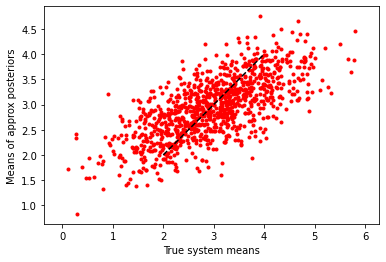

In [8]:
plt.plot(true_system_mns, est_post_mns, 'r.')
plt.plot([2, 4], [2, 4], 'k--')
plt.axis('equal')
plt.xlabel('True system means')
plt.ylabel('Means of approx posteriors')


In [9]:
cpd_mn = cpd(torch.ones(1)).item()
cpd_std = cpd.std_f(torch.ones(1)).item()

print('True prior mean vs CPD mean: ' + str(mn_0) + ' | ' + str(cpd_mn))
print('True prior mean vs CPD mean: ' + str(std_0) + ' | ' + str(cpd_std))

True prior mean vs CPD mean: 3 | 2.9381625652313232
True prior mean vs CPD mean: 1 | 0.9056249856948853
